*This jupyter notebook is part of Arizona State University's course CAS 503 (Fundamentals of Complex Systems Science: Collectives) and was written by Bryan Daniels.  It was last updated April 4, 2024.*

*The neural data we use in this module comes from the following publications (see [http://www.cns.nyu.edu/kianilab/Datasets.html](http://www.cns.nyu.edu/kianilab/Datasets.html)):*

* *Kiani R, Cueva CJ, Reppas JB, Newsome WT. (2014). Dynamics of neural population responses in prefrontal cortex indicate changes of mind on single trials. Current Biology. 24(13): 1542-1547. https://doi.org/10.1016/j.cub.2014.05.049*
* *Kiani R, Cueva CJ, Reppas JB, Peixoto D, Ryu SI, Newsome WT. (2015). Natural grouping of neural responses reveals spatially segregated clusters in prearcuate cortex. Neuron. 85(6): 1359-1373. https://dx.doi.org/10.1016/j.neuron.2015.02.014*

# Using Information Decomposition to Measure Neural Synergy

We saw in lecture how information theory can be used to define synergy quantitatively, in terms of the predictive power one gets from measuring groups of components simultaneously that is not available by measuring the components in isolation.

We also saw an example of neural activity measured in a macaque's brain carrying out a decision.  In this exercise, we will look at this real neural data, searching for information in individual neurons and pairs of neurons that best allow us to read the monkey's mind.

## Getting started

In [2]:
# We'll use matplotlib and seaborn, two popular python packages, to make plots.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'font.size': 18}) # increases font size on plots
# The "neural" package contains code I wrote for working with this neural dataset 
# and for calculating the information decomposition.
from neural.neuralData import loadBinnedSpikingData,loadBehaviorData
import neural.informationDecomposition as info
from pathlib import Path # to handle file paths across all operating systems

First we'll load the neural and behavioral data.

If you're interested in the experimental details: All times will be measured relative to the "go cue", when the monkey is signaled to indicate its choice.  We will focus here on 400 ms past the go cue, just after the monkey has indicated its choice. (The monkey's reaction time is around 250 ms.)  We will count neural action potentials ("spikes") that occur within a 100 ms time window centered on 400 ms.

In [3]:
dataFilename = Path('data/KianiEtAl2014/T33.mat')

alignName = 'go_cue'  
time = 400 # ms post-go cue
timeWindow = 100 # ms

binnedNeuralDataRaw = loadBinnedSpikingData(dataFilename,
                                            alignName=alignName,
                                            timeWindow=timeWindow,
                                            relativeMidTimes=[time,])
# (remove time index from dataframe since we're just looking at a single timepoint)
binnedNeuralData = binnedNeuralDataRaw.xs(time,level='time (ms)') 

# load data on which choice the monkey made in each trial
choiceData = loadBehaviorData(dataFilename)

Let's look at the data we have.  Note that there are 1778 trials, and for each trial we have the choice that the monkey made (direction 1 or 2) along with the measured number of action potentials made by each of 169 neural units (within the time window we specified above).

In [4]:
choiceData

Trial 0       2
Trial 1       2
Trial 2       1
Trial 3       2
Trial 4       2
             ..
Trial 1773    2
Trial 1774    1
Trial 1775    2
Trial 1776    1
Trial 1777    2
Length: 1778, dtype: uint8

In [5]:
binnedNeuralData

,Trial 0,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,...,Trial 1768,Trial 1769,Trial 1770,Trial 1771,Trial 1772,Trial 1773,Trial 1774,Trial 1775,Trial 1776,Trial 1777
neural unit,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,3,1,3,0,0,2,1,1,0,...,2,0,0,1,1,0,1,1,0,1
2,1,0,0,0,0,1,0,0,3,0,...,2,0,0,1,1,0,1,0,0,0
3,0,1,0,1,0,1,1,2,2,0,...,0,3,0,1,2,1,0,0,1,0
4,1,1,0,0,2,4,2,0,0,0,...,4,0,0,1,0,1,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,4,2,0,5,3,6,5,3,1,2,...,6,2,2,10,3,8,1,6,1,10
165,0,0,1,0,1,0,1,0,1,0,...,1,0,1,1,0,0,0,1,1,0
166,1,0,0,0,0,0,0,0,0,0,...,1,0,1,2,2,1,0,0,0,1


Now let's use the `histplot` function from the seaborn package to plot a histogram of the activity of neuron #78 across the 1778 trials.  (`binnedNeuralData.loc[neuronIndex]` is syntax for the pandas package that produces the row of `binnedNeuralData` at index `neuronIndex`.)

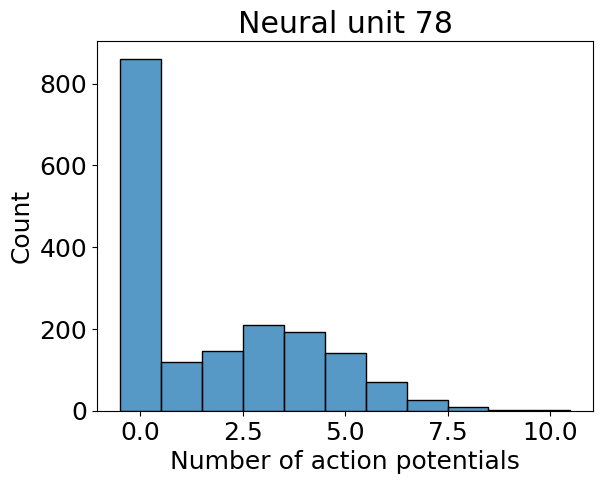

In [6]:
neuronIndex = 78
sns.histplot(binnedNeuralData.loc[neuronIndex],
             discrete=True)
plt.xlabel("Number of action potentials")
plt.title("Neural unit {}".format(neuronIndex));

We see that, during this time of the trial, neuron 78 often has no activity, but sometimes it fires a number of action potentials.

## Measuring mutual information

Now let's split this into two histograms, one for trials in which the monkey's choice was direction 1 and one for direction 2.  (There's a nice way in pandas to get just the data for trials in which the choice was 1: `binnedNeuralData.loc[neuronIndex,choiceData==1]`.)

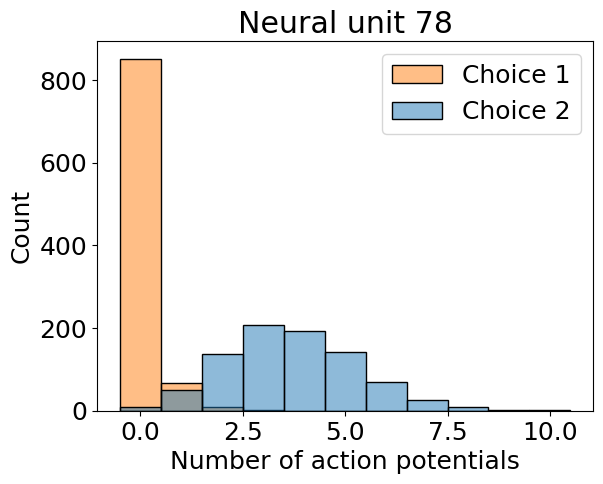

In [7]:
neuronIndex = 78
sns.histplot([binnedNeuralData.loc[neuronIndex,choiceData==2].array,
              binnedNeuralData.loc[neuronIndex,choiceData==1].array],
              discrete=True)
plt.xlabel("Number of action potentials")
plt.title("Neural unit {}".format(neuronIndex))
plt.legend(['Choice 1','Choice 2']);

Aha!  Neuron 78 appears to be a good indicator of the decision.

**❓Without doing an explicit calculation, about how many bits of information does neuron 78 carry about the decision?**  *Hint: How much uncertainty do you have about the decision before I tell you how many action potentials neuron 78 fired?  About how much uncertainty do you have after I tell you?*

**✳️ Answer:** 

Now let's use python to get a more precise estimate of the mutual information between neuron 78 and the decision.

The `discreteMutualInfo` function takes lists of discrete data sampled from two processes and returns an estimate of the mutual information between the two (in units of bits).

In [8]:
info.discreteMutualInfo( binnedNeuralData.loc[78], choiceData )

np.float64(0.8521956669210717)

So the activity of neuron 78 carries about 0.85 bits of information about the decision during this time window.

❓**Use the `discreteMutualInfo` function to find a neural unit that has very little mutual information with the decision.**

✳️ **Answer:** 

In [9]:
# ✳️ ** Answer: **   

❓**What do you expect the two histograms of neural activity to look like when the mutual information is small?  Explain your answer, and then check it by plotting the analogous histograms to the ones above for the neuron you found.**

✳️ **Answer:** 

In [10]:
# ✳️ ** Answer: **   

## Measuring neural synergy

Now we measure the amount of information that pairs of neurons carry collectively about the decision.

As an example, let's look at the pair of neural units with index 84 and 153.  
❓**First, use `discreteMutualInfo` as above to compute the information that neuron 84 and neuron 153 each carry individually about the decision.  Compare this to what we got with neuron 78 above.**

In [11]:
# ✳️ **Answer:**

Next, we'll ask how much information we can get about the decision if we measure *both* 84 and 153.  This is called the joint mutual information.  The function `discreteJointInfo` will estimate this for us:

In [12]:
neuronIndexA,neuronIndexB = 84,153
info.discreteJointInfo(choiceData,
                       binnedNeuralData.loc[neuronIndexA],
                       binnedNeuralData.loc[neuronIndexB])

np.float64(0.7141074899507975)

So there is some extra information that we gain by measuring both neurons.

Recall that in the information decomposition we saw in lecture, the joint mutual information can be written as a sum of the unique information provided by each neuron, the redundant information provided by both, and the synergistic information that you can only get by measuring both at the same time.  The following code will calculate this for us:

In [13]:
# set up the datasets to use
neuronIndexA,neuronIndexB = 84,153
neuralDataA = binnedNeuralData.loc[neuronIndexA]
neuralDataB = binnedNeuralData.loc[neuronIndexB]

# compute the mutual information decomposition values
uniqueA,uniqueB = info.unique(choiceData,neuralDataA,neuralDataB)
redundant =       info.redundancy(choiceData,neuralDataA,neuralDataB)
syn =             info.synergy(choiceData,neuralDataA,neuralDataB)
joint =           info.discreteJointInfo(choiceData,neuralDataA,neuralDataB)

# print out the results in a fancy table
print("Unique neuron {:<3}: {:<1.3f} bits".format( neuronIndexA, uniqueA ))
print("Unique neuron {:<3}: {:<1.3f} bits".format( neuronIndexB, uniqueB ))
print("Redundancy:        {:<1.3f} bits".format(redundant))
print("Synergy:           {:<1.3f} bits".format(syn))
print("                  ------------")
print("Total (joint):     {:<1.3f} bits".format(joint))

Unique neuron 84 : 0.002 bits
Unique neuron 153: 0.000 bits
Redundancy:        0.457 bits
Synergy:           0.255 bits
                  ------------
Total (joint):     0.714 bits


We can plot histograms similar to the previous section to get a better understanding for how this works.  The following code plots a separate 2D histogram for Choice 1 and Choice 2, showing the distribution of activity of the two neurons in each case:

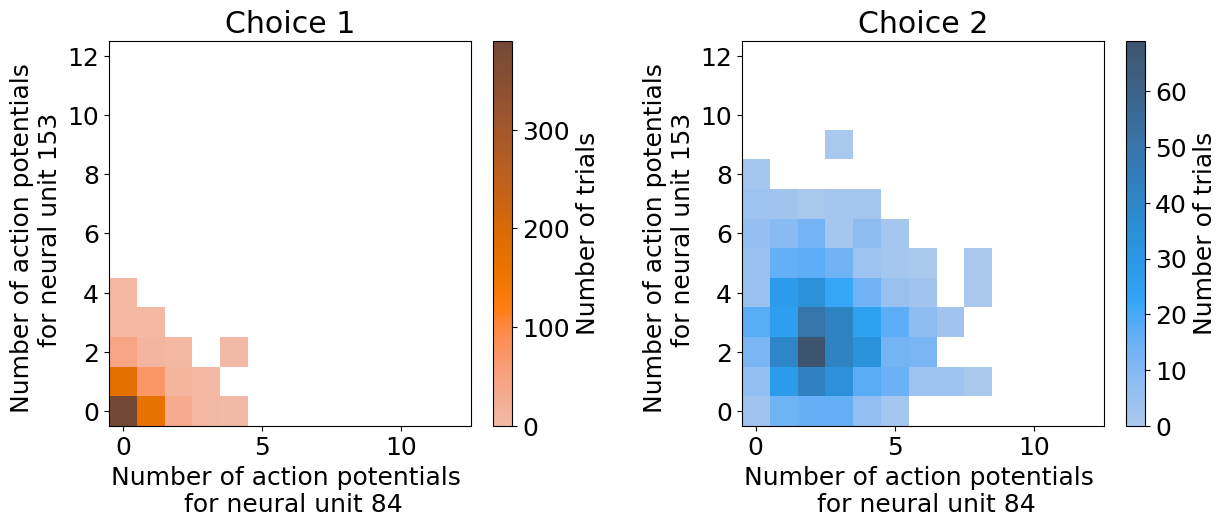

In [14]:
neuronIndexA,neuronIndexB = 84,153 

plt.figure(figsize=(14,5))
for choice in [1,2]:
    plt.subplot(1,2,choice)
    sns.histplot(binnedNeuralData.loc[:,choiceData==choice].T,
                 x=neuronIndexA,
                 y=neuronIndexB,
                 discrete=True,
                 color='C{}'.format(2-choice),
                 cbar=True,
                 cbar_kws={'label': 'Number of trials'})
    plt.axis(xmin=-0.5,xmax=12.5,ymin=-0.5,ymax=12.5)
    plt.title("Choice {}".format(choice))
    plt.xlabel("Number of action potentials \n for neural unit {}".format(neuronIndexA))
    plt.ylabel("Number of action potentials \n for neural unit {}".format(neuronIndexB))
plt.subplots_adjust(wspace=0.4) # change horizontal spacing of plots

We can also plot the corresponding histograms for the individual neurons 84 and 153 (which, by the way, correspond to summing the above 2D histograms in the vertical and horizontal directions, respectively):

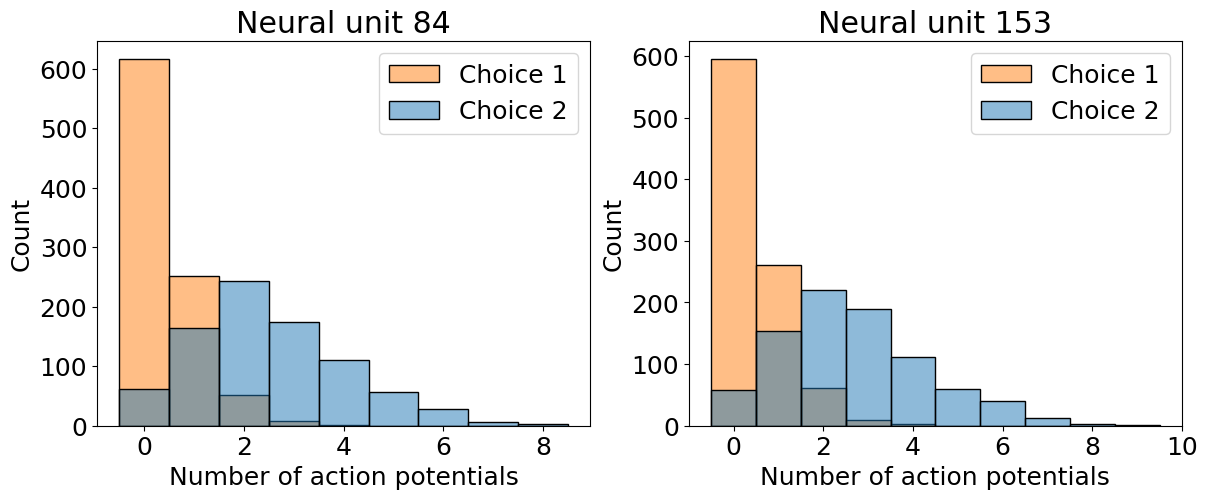

In [15]:
plt.figure(figsize=(14,5))
for i,neuronIndex in enumerate([84,153]):
    plt.subplot(1,2,i+1)
    sns.histplot([binnedNeuralData.loc[neuronIndex,choiceData==2].array,
                  binnedNeuralData.loc[neuronIndex,choiceData==1].array],
                  discrete=True)
    plt.xlabel("Number of action potentials")
    plt.title("Neural unit {}".format(neuronIndex))
    plt.legend(['Choice 1','Choice 2']);

Let's try to see intuitively where redundant and synergistic information comes from in these neurons.

First, **redundant** information corresponds to being able to predict the output choice equally well by measuring the activity of either neuron individually.

❓**Which plots above give us a hint that the neurons carry redundant information?**

✳️ **Answer:**

Second, **synergistic** information corresponds to being able to predict the output choice better after accounting for any unique or redundant information provided by measuring neurons individually.

Understanding how synergy arises in this case is somewhat subtle.  We can gain some intuition of redundancy and synergy by instead constructing theoretical examples of perfect correlation and "pure" synergy.

## Perfect correlation

If two neurons are very correlated, we might expect them to carry redundant information.  
❓**What do you predict the unique, redundant, synergistic, and joint information will be for two neurons that are perfectly correlated?  Check your answer by using the above information decomposition code to compute an example.** *Hint: Perfectly correlated neurons would always have exactly the same firing rate (or be rescaled versions of one another).*

✳️ **Answer:** 

In [16]:
# ✳️ **Answer:**

## Pure synergy?

To understand where informational synergy comes from, sometimes it's useful to think about a hypothetical case with *only* synergy.  The simplest such example is the "exclusive OR" function, which takes two binary numbers (each 0 or 1) and returns 1 only if the two numbers are different, returning 0 otherwise.

The following code creates lists of random 0s and 1s and then computes "exclusive OR" of the two: 

In [17]:
numSamples = 1000
X1data = np.random.randint(2,size=numSamples)
X2data = np.random.randint(2,size=numSamples)

XORdata = np.logical_xor(X1data,X2data)

Here's what the data look like:

In [18]:
pd.DataFrame(np.transpose([X1data,X2data,XORdata]),columns=['X1data','X2data','XORdata'])

,X1data,X2data,XORdata
0,0,0,0
1,1,1,0
2,0,1,1
3,1,0,1
4,0,1,1
...,...,...,...
995,1,1,0
996,1,1,0
997,0,0,0
998,0,0,0


❓**Use the above information decomposition code to verify that XOR produces "pure synergy".** *Hint: Because the code estimates the values from our finite dataset, you may get values that are only close to pure synergy.*

In [19]:
# ✳️ **Answer:**

❓***Why* is this case purely synergistic?** *Hint: Think about how much you know about the output if you are able to measure only one of X1 or X2, and compare it to the case in which you can measure both X1 and X2. If you are like me and it helps to think in pictures, you might try sketching histograms like we had above, either using code or just on a piece of paper.*

✳️ **Answer:** 

## Bonus: Wisdom of the crowd

Note that the pair of synergistic neurons contains more information in a similar way to the "wisdom of the crowd": When noise happens to disrupt the information of one neuron, the other neuron can compensate.  We can make this analogy with the cow-weight-guessing game more explicit by looking at whether the *average* (or, equivalently, the *sum*) over multiple neurons has more mutual information with the decision.  

**Bonus question (for nothing but bragging rights):**

⚛️ **Find a set of neurons whose sum predicts the decision better than any of the individual or pairs of neurons we looked at so far.  How large can you make the mutual information?**

In [20]:
# ✴️ **Answer:**